In [1]:

# Referenciando o google drive
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import shutil
shutil.copy("/content/drive/MyDrive/RenatoBanzai_quali/Dados/dataset4.zip", "./")

#2min

'./dataset4.zip'

In [3]:
!unzip -qq "./dataset4.zip"
#1min

In [4]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [5]:
trans = transforms.Compose([
        transforms.Resize(size=(224,224)),
        #transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [6]:
# Load the Data

# Set train and valid directory paths

dataset = 'dataset4'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'test')



# Batch size
bs = 512

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=trans),
    'valid': datasets.ImageFolder(root=valid_directory, transform=trans),
    'test': datasets.ImageFolder(root=test_directory, transform=trans)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True, num_workers=2)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True, num_workers=2)
test_data_loader = DataLoader(data['test'], num_workers=2)

68
{0: 'Abramites hypselonotus', 1: 'Acestrorhynchus pantaneiro', 2: 'Apareiodon affinis', 3: 'Aphyocharax anisitsi', 4: 'Aphyocharax paraguayensis', 5: 'Aphyocharax rathbuni', 6: 'Apistogramma borellii', 7: 'Apistogramma trifasciata', 8: 'Apteronotus albifrons', 9: 'Astronotus crassipinnis', 10: 'Brochis britskii', 11: 'Brochis splendens', 12: 'Brycon hilarii', 13: 'Bujurquina vittata', 14: 'Callichthys callichthys', 15: 'Catathyridium jenynsii', 16: 'Catoprion mento', 17: 'Cichlasoma dimerus', 18: 'Corydoras aeneus', 19: 'Corydoras hastatus', 20: 'Crenicichla lepidota', 21: 'Eigenmannia virescens', 22: 'Gasteropelecus sternicla', 23: 'Gymnocorymbus ternetzi', 24: 'Gymnogeophagus balzanii', 25: 'Gymnotus inaequilabiatus', 26: 'Hemigrammus ulreyi', 27: 'Hoplias malabaricus', 28: 'Hoplosternum littorale', 29: 'Hyphessobrycon anisitsi', 30: 'Hyphessobrycon elachys', 31: 'Hyphessobrycon eques', 32: 'Hyphessobrycon herbertaxelrodi', 33: 'Laetacara dorsigera', 34: 'Lepidosiren paradoxa', 35

In [7]:
train_data_size, valid_data_size, test_data_size

(46400, 3871, 3900)

In [8]:
efficientnet = models.efficientnet_b0(pretrained=True)
efficientnet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 170MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Freeze model parameters
for param in efficientnet.parameters():
    param.requires_grad = False

In [10]:
# Change the final layer of AlexNet Model for Transfer Learning
efficientnet.classifier[1] = nn.Linear(in_features=1280, out_features=68)
efficientnet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
efficientnet.cuda()
summary(efficientnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [12]:
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.001)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [13]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        #if avg_valid_acc > 0.7:
        #  return model, history

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        #torch.save(model, '/content/drive/MyDrive/RenatoBanzai_quali/Dados/model_'+str(epoch)+'.pt')

    return model, history

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#num_epochs = 20
num_epochs = 20
trained_model, history = train_and_validate(efficientnet, loss_func, optimizer, num_epochs)

#l4gpu 142s/epoch

Epoch: 1/20
Epoch : 001, Training: Loss: 2.7627, Accuracy: 39.2888%, 
		Validation : Loss : 1.8925, Accuracy: 58.5120%, Time: 86.9445s
Epoch: 2/20
Epoch : 002, Training: Loss: 1.6764, Accuracy: 62.7522%, 
		Validation : Loss : 1.4694, Accuracy: 64.7636%, Time: 88.6345s
Epoch: 3/20
Epoch : 003, Training: Loss: 1.3596, Accuracy: 68.0797%, 
		Validation : Loss : 1.3128, Accuracy: 67.4761%, Time: 85.9945s
Epoch: 4/20
Epoch : 004, Training: Loss: 1.1935, Accuracy: 71.0970%, 
		Validation : Loss : 1.2259, Accuracy: 69.4394%, Time: 86.6022s
Epoch: 5/20
Epoch : 005, Training: Loss: 1.0939, Accuracy: 72.8211%, 
		Validation : Loss : 1.1670, Accuracy: 70.1111%, Time: 85.6867s
Epoch: 6/20
Epoch : 006, Training: Loss: 1.0134, Accuracy: 74.7888%, 
		Validation : Loss : 1.1312, Accuracy: 70.5502%, Time: 87.9062s
Epoch: 7/20
Epoch : 007, Training: Loss: 0.9533, Accuracy: 75.6983%, 
		Validation : Loss : 1.1083, Accuracy: 70.9894%, Time: 86.4686s
Epoch: 8/20
Epoch : 008, Training: Loss: 0.9031, Accura

In [15]:
torch.save(history, '/content/drive/MyDrive/RenatoBanzai_quali/Codigo/'+'history_eff.pt')
torch.save(trained_model, '/content/drive/MyDrive/RenatoBanzai_quali/Codigo/'+'model_eff.pt')



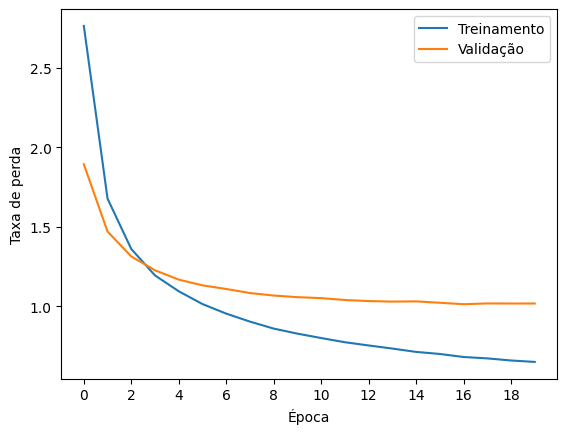

In [35]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Treinamento', 'Validação'])
plt.xlabel('Época')
plt.ylabel('Taxa de perda')
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.savefig(dataset+'_loss_curve.png')
plt.show()

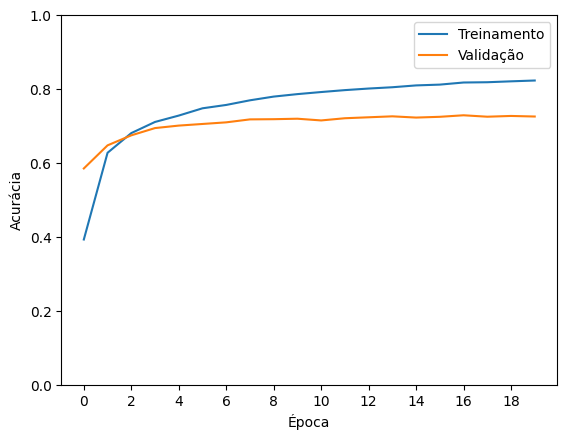

In [36]:
plt.plot(history[:,2:4])
plt.legend(['Treinamento', 'Validação'])
plt.xlabel('Época')
plt.xticks([0,2,4,6,8,10,12,14,16,18])
plt.ylabel('Acurácia')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [18]:
import cv2

def predict(model, test_image_name, new=False):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    model.cuda()
    transform = trans
    if new==False:
      test_image = Image.open(test_image_name)
    else:
      test_image = cv2.imread(test_image_name)
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB )
      test_image = Image.fromarray(test_image)

    plt.imshow(test_image)
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)

        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

Predcition 1 : Salminus brasiliensis , Score:  70693.31
Predcition 2 : Apistogramma borellii , Score:  16.744135
Predcition 3 : Prochilodus lineatus , Score:  14.773385


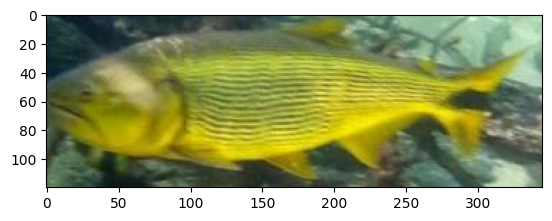

In [19]:
predict(trained_model, "/content/dataset4/test/Salminus brasiliensis/20_09320.jpg")

Predcition 1 : Abramites hypselonotus , Score:  520973.75
Predcition 2 : Corydoras hastatus , Score:  19.471102
Predcition 3 : Gymnocorymbus ternetzi , Score:  16.83169


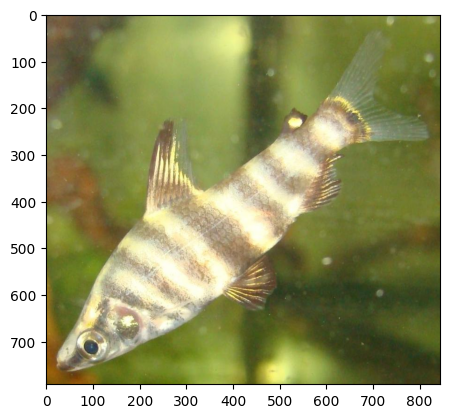

In [20]:
predict(trained_model, "/content/dataset4/test/Abramites hypselonotus/01_00219.jpg")

Predcition 1 : Abramites hypselonotus , Score:  879.0724
Predcition 2 : Otocinclus vittatus , Score:  8.257776
Predcition 3 : Sturisoma barbatum , Score:  5.574008


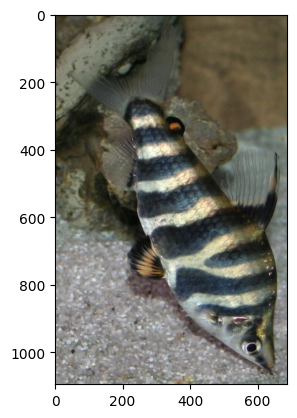

In [21]:
predict(trained_model,"/content/dataset4/test/Abramites hypselonotus/01_00224.jpg")

Predcition 1 : Acestrorhynchus pantaneiro , Score:  106.506874
Predcition 2 : Aphyocharax paraguayensis , Score:  26.40117
Predcition 3 : Rhaphiodon vulpinus , Score:  6.3975635


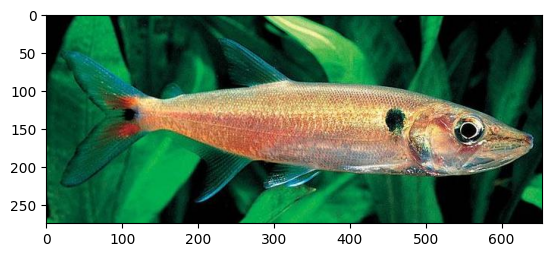

In [22]:
predict(trained_model,"/content/dataset4/test/Acestrorhynchus pantaneiro/04_00725.jpg")

Predcition 1 : Brycon hilarii , Score:  16.17915
Predcition 2 : Rhaphiodon vulpinus , Score:  11.95434
Predcition 3 : Aphyocharax paraguayensis , Score:  4.4302864


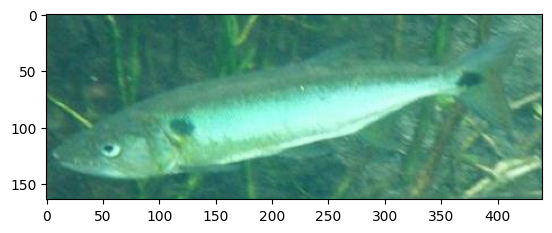

In [23]:
predict(trained_model,"/content/dataset4/test/Acestrorhynchus pantaneiro/04_00736.jpg")

Predcition 1 : Apareiodon affinis , Score:  5936.15
Predcition 2 : Leporinus striatus , Score:  235.80171
Predcition 3 : Crenicichla lepidota , Score:  41.893543


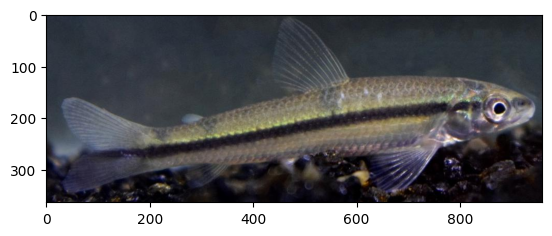

In [24]:
predict(trained_model,"/content/dataset4/test/Apareiodon affinis/52_20487.jpg")

Predcition 1 : Leporinus striatus , Score:  215.53415
Predcition 2 : Apareiodon affinis , Score:  68.72858
Predcition 3 : Apistogramma trifasciata , Score:  10.878996


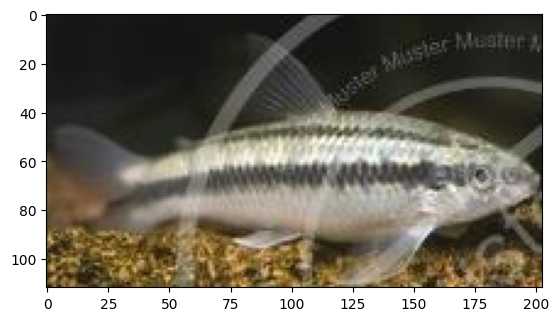

In [25]:
predict(trained_model,"/content/dataset4/test/Apareiodon affinis/52_20493.jpg")

Predcition 1 : Eigenmannia virescens , Score:  27.58055
Predcition 2 : Aphyocharax anisitsi , Score:  0.21710023
Predcition 3 : Megalamphodus megalopterus , Score:  0.10611178


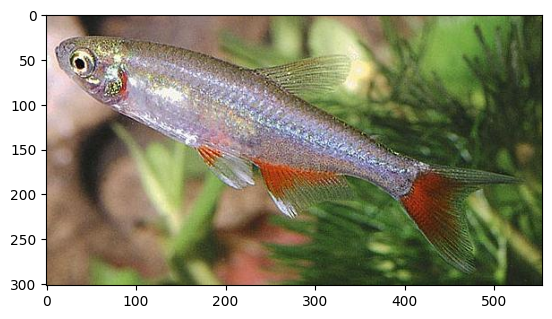

In [26]:
predict(trained_model,"/content/dataset4/test/Aphyocharax anisitsi/05_00873.jpg")

In [27]:
test_loss = 0
test_acc = 0
all_labels = []
all_predictions = []

# Validation - No gradient tracking needed
with torch.no_grad():

    # Set to evaluation mode
    trained_model.eval()

    # Validation loop
    for j, (inputs, labels) in enumerate(test_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        all_labels.append(labels.item())

        # Forward pass - compute outputs on input data using the model
        outputs = trained_model(inputs)

        # Compute loss
        loss = loss_func(outputs, labels)

        # Compute the total loss for the batch and add it to valid_loss
        test_loss += loss.item() * inputs.size(0)

        # Calculate validation accuracy
        ret, predictions = torch.max(outputs.data, 1)
        all_predictions.append(predictions.item())
        correct_counts = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc
        test_acc += acc.item() * inputs.size(0)

        #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

test_acc/test_data_size

0.7507692307692307

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# or:
# from tensorflow.math import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt


cm = confusion_matrix(all_labels, all_predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
precision

array([0.93023256, 0.7826087 , 0.75      , 0.73786408, 0.68181818,
       0.75      , 0.81395349, 0.82692308, 0.72727273, 0.8974359 ,
       0.71428571, 0.69444444, 0.80299786, 0.56756757, 0.56521739,
       0.85714286, 0.73913043, 0.57575758, 0.796875  , 0.62650602,
       0.69565217, 0.77777778, 0.79411765, 0.75728155, 0.58974359,
       0.45      , 0.82608696, 0.78787879, 0.7       , 0.61666667,
       0.68421053, 0.78977273, 0.82795699, 0.67605634, 0.61363636,
       0.8       , 0.60526316, 0.83870968, 0.77862595, 0.76785714,
       0.7       , 0.74468085, 0.86956522, 0.60465116, 0.65      ,
       0.8       , 0.875     , 0.625     , 0.73076923, 0.84615385,
       0.94339623, 0.6744186 , 0.70588235, 0.56666667, 0.69767442,
       0.85714286, 0.69230769, 0.77121771, 0.75      , 0.83333333,
       0.83673469, 0.84210526, 0.82051282, 0.73529412, 0.8       ,
       0.73333333, 0.62264151, 0.75757576])

In [29]:
np.mean(precision)

np.float64(0.739726253957545)

In [30]:
top_k_indices = np.argpartition(precision, -10)[-10:]
for x in top_k_indices:
  print(idx_to_class[x], precision[x])

Leporinus striatus 0.8387096774193549
Schizodon isognathus 0.8421052631578947
Platydoras armatulus 0.8461538461538461
Pseudotylosurus angusticeps 0.8571428571428571
Catathyridium jenynsii 0.8571428571428571
Otocinclus vittatus 0.8695652173913043
Pimelodus ornatus 0.875
Astronotus crassipinnis 0.8974358974358975
Abramites hypselonotus 0.9302325581395349
Potamotrygon motoro 0.9433962264150944


In [31]:
bot_k_indices = np.argpartition(precision, 10)[:10]
for x in bot_k_indices:
  print(idx_to_class[x], precision[x])

Gymnotus inaequilabiatus 0.45
Callichthys callichthys 0.5652173913043478
Pseudoplatystoma corruscans 0.5666666666666667
Bujurquina vittata 0.5675675675675675
Cichlasoma dimerus 0.5757575757575758
Gymnogeophagus balzanii 0.5897435897435898
Paulicea luetkeni 0.6046511627906976
Leporinus macrocephalus 0.6052631578947368
Lepidosiren paradoxa 0.6136363636363636
Hyphessobrycon anisitsi 0.6166666666666667


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("precision_score", precision_score(all_labels, all_predictions, average='weighted'))
print("recall_score", recall_score(all_labels, all_predictions, average='weighted'))
print("f1_score", f1_score(all_labels, all_predictions, average='weighted'))

precision_score 0.7520798080575823
recall_score 0.7507692307692307
f1_score 0.7477315051877077


In [33]:
import torch.nn.functional as Fu
for param in trained_model.parameters():
  param.requires_grad = True


def grad_cam_efficientnet(model, image_path):
  with torch.enable_grad():
    img = Image.open(image_path)
    input_tensor = trans(img)
    model.eval()

    target_layer = model.features[8]
    activations = {}
    grads = {}

    def forward_hook(module, input, output):
        #print("forward_hook")
        activations['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        #print("backward_hook")
        grads['value'] = grad_out[0].detach()

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor.unsqueeze(0).cuda())              # shape (1, 1000)
    class_idx = output.argmax(dim=1).item()   # ou escolha manualmente
    score = output[0, class_idx]

    model.zero_grad()
    score.cuda().backward()

    # a) médias globais dos gradientes (α_k no artigo)
    weights = grads['value'].mean(dim=(2, 3), keepdim=True)  # shape (C,1,1)

    # b) combinação linear das feature maps ponderadas
    gcam = (weights * activations['value']).sum(dim=1, keepdim=True)

    # c) ReLU (descartamos valores negativos)
    gcam = Fu.relu(gcam)

    # d) normalizar para [0,1]
    gcam = Fu.interpolate(gcam, size=(224, 224), mode='bilinear', align_corners=False)
    gcam = gcam[0, 0].cpu().numpy()
    gcam = (gcam - gcam.min()) / (gcam.max() - gcam.min() + 1e-8)

    heatmap = plt.cm.jet(gcam)[:, :, :3]      # remove canal alfa
    heatmap = (heatmap * 255).astype(np.uint8)

    # converter entrada pré-processada de volta para RGB
    inv_norm = transforms.Normalize(
        mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                                  [0.229, 0.224, 0.225])],
        std=[1/s for s in [0.229, 0.224, 0.225]]
    )
    img_rgb = inv_norm(input_tensor).clamp(0, 1).permute(1, 2, 0).numpy()
    img_rgb = (img_rgb * 255).astype(np.uint8)

    # sobreposição simples: 40 % heatmap + 60 % imagem
    overlay = (0.6 * img_rgb + 0.4 * heatmap).astype(np.uint8)

    backward_handle.remove()
    forward_handle.remove()
    return (overlay, class_idx)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


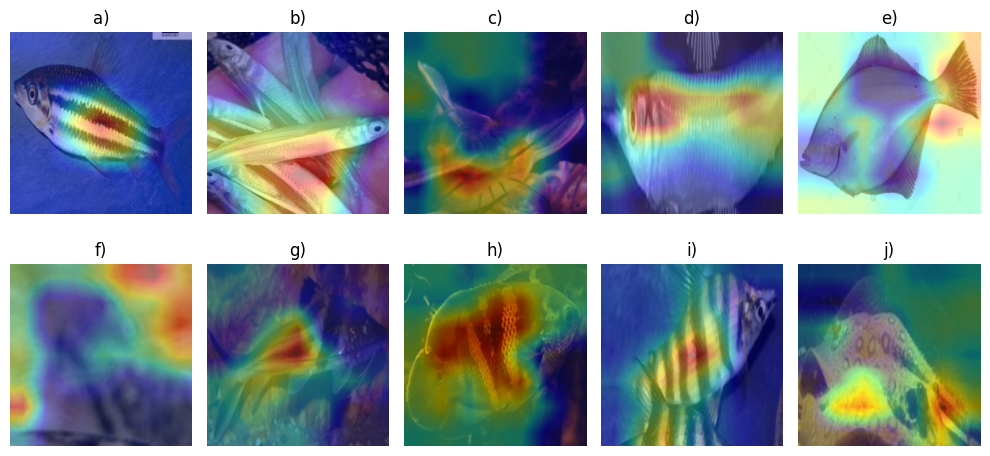

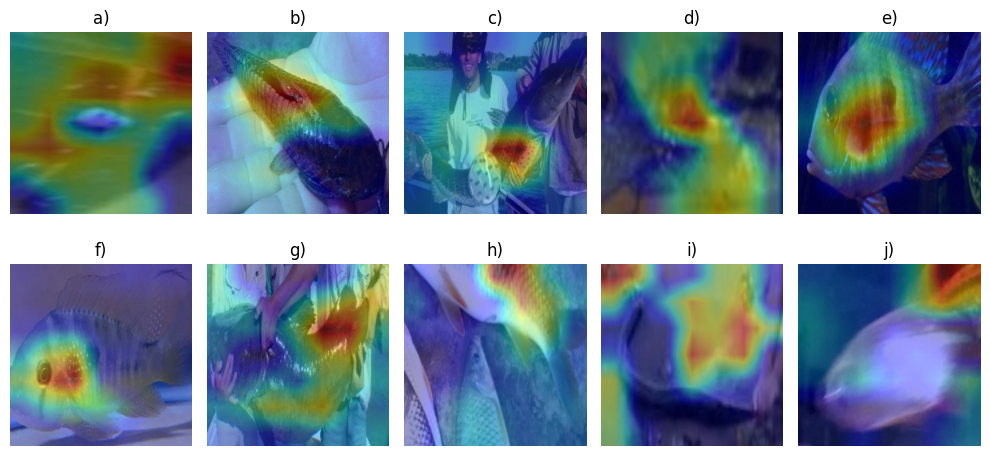

In [34]:
#print gradcam grid
import os

def print_gradcam_grid(k_indices):
  title_char = 65
  linha = 0
  coluna = 0
  test_path= "/content/dataset4/test/"
  fig, axes = plt.subplots(2, 5, figsize=(10, 5)) # Create a 2x2 grid of subplots
  for x in k_indices:
    specie_path=test_path + idx_to_class[x]
    list_files = os.listdir(specie_path)
    img_path = specie_path + "/" + list_files[2]
    grafico, class_idx = grad_cam_efficientnet(trained_model, img_path)
    axes[linha, coluna].axis('off')
    axes[linha, coluna].imshow(grafico)
    axes[linha, coluna].set_title(f"{chr(title_char).lower()})")
    if coluna >= 4:
      coluna = 0
      linha += 1
    else:
      coluna += 1
    title_char += 1
  plt.tight_layout()
  plt.show()

    #print(idx_to_class[x], precision[x])


print_gradcam_grid(top_k_indices)
print_gradcam_grid(bot_k_indices)